# process reuters data from nltk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

td = timedelta (days = 0, hours =  0 , minutes = 53)
Anfang = datetime.now()
Start = Anfang + td

In [2]:
import pickle

from tp_utils import *

import nltk
from nltk.corpus import reuters

from string import punctuation
translator = str.maketrans(' ', ' ', punctuation)
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

In [3]:
def normalize_text(doc):
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ')
        lower = sent.lower()
        nopunc = lower.translate(translator)
        words = nopunc.split()
        nostop = [w for w in words if w not in stoplist]
        no_numbers = [w if not w.isdigit() else '#' for w in nostop]
        stemmed = [stemmer.stem(w) for w in no_numbers]
        tokens += stemmed
    return tokens

In [4]:
import liwc
import re
from collections import Counter

LIWC_DICTIONARY = '/home/xhta/Robot/liwc/timeori.dic'
parse, cat_names = liwc.load_token_parser(LIWC_DICTIONARY)

def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

In [5]:
import spacy
from spacy.lang.en import English
nlp = English()

nlp.add_pipe(nlp.create_pipe('sentencizer'))
nlp2 = spacy.load('en_core_web_sm')

In [6]:
dfre = pd.DataFrame(index = range(0,0), columns=['cats', 'tetr', 'leng', 'nwords', 'ntoks', 'nverbs', 'npast', 'npresent', 'nfuture', 'nfpast', 'nfpresent', 'nffuture', 'rt'], dtype = int)

for col in [ 'tetr', 'leng', 'nwords', 'ntoks', 'nverbs', 'npast', 'npresent', 'nfuture', 'nfpast', 'nfpresent', 'nffuture']:
    dfre[col] = dfre[col].astype(int)

dfre['cats'] = dfre['cats'].astype(object)
dfre['rt'] = dfre['rt'].astype(object)

fids = reuters.fileids()

In [7]:
i = 0
for fid in fids:
    rt = reuters.raw(fid)
    rtc = rt.replace("\n", "")
    rtc = rtc.replace("\'s", "'s")
    dfre.at[fid, 'rt'] = rtc

    dfre.at[fid, 'leng'] = len(rtc)
    dfre.at[fid, 'cats'] = reuters.categories(fid)
    if "test" in fid:
        dfre.at[fid, 'tetr'] = 0
    else: dfre.at[fid, 'tetr'] = 1

    doc = nlp2(dfre.loc[fid, 'rt'])

    cltoks = normalize_text(doc)
    ntoks = [str(token).lower() for token in list(doc) if (not token.is_punct) & (not token.is_space) & (not token.is_stop) & (str(token) in cltoks)]
    dfre.at[fid, 'ntoks'] = len(ntoks)

    sentences = [sent.string.strip() for sent in doc.sents]   # to do : replace by nltk.sent_tokenize ? might speed up
    dfre.at[fid, 'nsents'] =  len(sentences)
    dfre.at[fid, 'nwords'] = len([token for token in doc if not token.is_punct])

    dfre.at[fid, 'nverbs'] = len([w for w in list(doc) if w.tag_.startswith('V')])

    npast, npresent, nfuture, antpast, antpresent, antfuture = spacy_parse(doc)
#
    dfre.loc[fid, 'npast'] = npast
    dfre.loc[fid, 'npresent'] = npresent
    dfre.loc[fid, 'nfuture'] = nfuture

    dfre.loc[fid, 'antpast'] = antpast
    dfre.loc[fid, 'antpresent'] = antpresent
    dfre.loc[fid, 'antfuture'] = antfuture

    nfpast, nfpresent, nffuture, antfpast, antfpresent, antffuture = liwc_parse(rtc)
#
    dfre.loc[fid, 'nfpast'] = nfpast
    dfre.loc[fid, 'nfpresent'] = nfpresent
    dfre.loc[fid, 'nffuture'] = nffuture

    dfre.loc[fid, 'antfpast'] = antfpast
    dfre.loc[fid, 'antfpresent'] = antfpresent
    dfre.loc[fid, 'antffuture'] = antffuture

    dfre.loc[fid, 'ldeont'] = deont_parse(rtc)
    dfre.loc[fid, 'lmodal'] = modal_parse(rtc)
#
    if (i %579 == 0):
        je = datetime.now() + td
        pkl_fname = 'pj_dfre_full.' + je.strftime('%Y%m%d_%H%M%S' + ".pkl")
        print ("jetzt:{0}  i:{1} ... interim checkpointing to {2}".format(je, i, pkl_fname))
        dfre.to_pickle(pkl_fname)
    i = i + 1


jetzt:2019-06-29 11:00:18.989071  i:0 ... interim checkpointing to pj_dfre_full.20190629_110018.pkl
jetzt:2019-06-29 11:02:59.754038  i:579 ... interim checkpointing to pj_dfre_full.20190629_110259.pkl
jetzt:2019-06-29 11:05:24.861166  i:1158 ... interim checkpointing to pj_dfre_full.20190629_110524.pkl
jetzt:2019-06-29 11:09:13.789672  i:1737 ... interim checkpointing to pj_dfre_full.20190629_110913.pkl
jetzt:2019-06-29 11:12:15.715937  i:2316 ... interim checkpointing to pj_dfre_full.20190629_111215.pkl
jetzt:2019-06-29 11:14:39.987723  i:2895 ... interim checkpointing to pj_dfre_full.20190629_111439.pkl
jetzt:2019-06-29 11:17:53.625597  i:3474 ... interim checkpointing to pj_dfre_full.20190629_111753.pkl
jetzt:2019-06-29 11:21:06.847772  i:4053 ... interim checkpointing to pj_dfre_full.20190629_112106.pkl
jetzt:2019-06-29 11:24:04.602619  i:4632 ... interim checkpointing to pj_dfre_full.20190629_112404.pkl
jetzt:2019-06-29 11:27:08.631866  i:5211 ... interim checkpointing to pj_dfre

In [8]:
je = datetime.now() + td
pkl_fname = 'pj_dfre_full.' + je.strftime('%Y%m%d_%H%M%S' + ".pkl")
print ("jetzt:{0}  ... final checkpointing to {1}".format(je, pkl_fname))
dfre.to_pickle(pkl_fname)

jetzt:2019-06-29 11:58:19.502194  ... final checkpointing to pj_dfre_full.20190629_115819.pkl


In [9]:
sAvepast = dfre["antpast"].mean()
sAvepresent = dfre["antpresent"].mean()
sAvezfuture = dfre["antfuture"].mean()

lAvepast = dfre["antfpast"].mean()
lAvepresent = dfre["antfpresent"].mean()
lAvezfuture = dfre["antffuture"].mean()

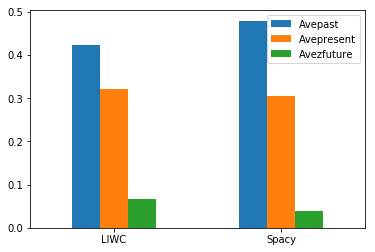

In [10]:
modfplot = pd.DataFrame({'Avepast' : [lAvepast, sAvepast], 'Avepresent': [lAvepresent, sAvepresent], 'Avezfuture': [lAvezfuture, sAvezfuture]}, index =
 ['LIWC', 'Spacy'] )
modfplot.plot.bar(rot=0)
plt.show()

In [11]:
dfre.head()

,cats,tetr,leng,nwords,ntoks,nverbs,npast,npresent,nfuture,nfpast,...,rt,nsents,antpast,antpresent,antfuture,antfpast,antfpresent,antffuture,ldeont,lmodal
test/14826,[trade],0.0,4605.0,822.0,139.0,100.0,28.0,25.0,3.0,27.0,...,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,32.0,0.500000,0.446429,0.053571,0.415385,0.476923,0.107692,0.0,9.0
test/14828,[grain],0.0,646.0,123.0,23.0,14.0,8.0,2.0,0.0,7.0,...,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,5.0,0.800000,0.200000,0.000000,0.875000,0.125000,0.000000,0.0,0.0
test/14829,"[crude, nat-gas]",0.0,1120.0,199.0,37.0,24.0,7.0,3.0,2.0,7.0,...,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,7.0,0.583333,0.250000,0.166667,0.437500,0.312500,0.250000,0.0,0.0
test/14832,"[corn, grain, rice, rubber, sugar, tin, trade]",0.0,938.0,171.0,50.0,16.0,11.0,2.0,0.0,8.0,...,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,8.0,0.846154,0.153846,0.000000,0.888889,0.000000,0.111111,0.0,0.0
test/14833,"[palm-oil, veg-oil]",0.0,1022.0,178.0,40.0,25.0,6.0,5.0,0.0,7.0,...,INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,7.0,0.545455,0.454545,0.000000,0.500000,0.357143,0.142857,0.0,2.0
